### Import Libs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from collections import Counter

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

### Function Definitions

In [6]:
def plot_bar_percentages(g, include_values=False, label_type='edge', padding=3, **kwargs):
    '''
    add pct label for each bar in a bar chart
    '''
    if len(g.containers) > 1:
        total = sum([container.datavalues for container in g.containers])
        for i in range(len(g.containers)):
            labels = [f'{j * 100 :.1f}%' for j in g.containers[i].datavalues / total]
            if include_values:
                values = g.containers[i].datavalues
                labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
            g.bar_label(g.containers[i], labels=labels, label_type=label_type, padding=padding, **kwargs)
    else:
        labels = [f'{i * 100 :.1f}%' for i in g.containers[0].datavalues / sum(g.containers[0].datavalues)]
        if include_values:
            values = g.containers[0].datavalues
            labels = [f'{int(value)} ({label})' for value, label in zip(values, labels)]
        g.bar_label(g.containers[0], labels=labels, label_type=label_type, padding=padding, **kwargs)

def pct_label(pct):
    '''
    Add decimal value if pct not int for pie charts
    '''
    if round(pct, 1) != int(pct):
        return f"{pct:.1f}%"
    return f"{int(pct)}%"

def pct_adjust(autopcts, color = 'white', threshold = 5, distance = 1.4):
    '''
    Adjust percentage label color and position in a pie chart
    '''
    for pct in autopcts:
            # Set pct color to white
            pct.set_color(color)

            # Modify label positions for percentages < 5%
            if float(pct.get_text().strip('%')) < threshold:
                pos = pct.get_position()
                pct.set_position(tuple(map(lambda x: x * distance, pos)))

### Data Wrangling and Tidyng

In [7]:
info = pd.read_csv('./species_info.csv')
obs = pd.read_csv('./observations.csv')

print('*' * 50, 'SPECIES INFO DATA SET', '*' * 50)
display(info.head())
print(info.shape)
print('*' * 50, 'OBSERVATIONS DATA SET', '*' * 50)
display(obs.head())
print(obs.shape)

************************************************** SPECIES INFO DATA SET **************************************************


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


(5824, 4)
************************************************** OBSERVATIONS DATA SET **************************************************


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


(23296, 3)


In [8]:
# Rename missing values in conservation_status column
info.conservation_status.fillna('Unclassified', inplace=True)

# Add protected status
info['is_protected'] = info.conservation_status != 'Unclassified'

# Prepare data set to be merged
info_mod = info.drop(columns='common_names')

# Remove Duplicated rows to have a unique scientific_name per row
info_mod.drop_duplicates(inplace=True)

In [9]:
# Check if all scientific names are unique
info_mod.scientific_name.value_counts()

scientific_name
Oncorhynchus mykiss                2
Canis lupus                        2
Clethrionomys gapperi gapperi      1
Valeriana dioica var. sylvatica    1
Gaultheria humifusa                1
                                  ..
Viola pubescens                    1
Viola porterana                    1
Viola pedata                       1
Viola odorata                      1
Tribulus terrestris                1
Name: count, Length: 5541, dtype: int64

In [10]:
# Check scientific names that are not unique
display(info_mod[info_mod.scientific_name.isin(['Oncorhynchus mykiss', 'Canis lupus'])])

,category,scientific_name,conservation_status,is_protected
8,Mammal,Canis lupus,Endangered,True
560,Fish,Oncorhynchus mykiss,Unclassified,False
3020,Mammal,Canis lupus,In Recovery,True
3283,Fish,Oncorhynchus mykiss,Threatened,True


In [11]:
# Remove first appearance of each species, as it shows an evolution in their conservation_status
info_mod = info_mod.drop([8, 560]).reset_index(drop=True)
info_mod

,category,scientific_name,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Unclassified,False
1,Mammal,Bos bison,Unclassified,False
2,Mammal,Bos taurus,Unclassified,False
3,Mammal,Ovis aries,Unclassified,False
4,Mammal,Cervus elaphus,Unclassified,False
...,...,...,...,...
5536,Vascular Plant,Solanum parishii,Unclassified,False
5537,Vascular Plant,Solanum xanti,Unclassified,False
5538,Vascular Plant,Parthenocissus vitacea,Unclassified,False
5539,Vascular Plant,Vitis californica,Unclassified,False


In [12]:
# Create DF with only classified species
classified = info_mod[info_mod.conservation_status != 'Unclassified']
classified

,category,scientific_name,conservation_status,is_protected
7,Mammal,Canis latrans,Species of Concern,True
8,Mammal,Canis rufus,Endangered,True
28,Mammal,Eptesicus fuscus,Species of Concern,True
29,Mammal,Lasionycteris noctivagans,Species of Concern,True
32,Mammal,Myotis austroriparius,Species of Concern,True
...,...,...,...,...
5049,Vascular Plant,Callitriche marginata,Species of Concern,True
5140,Vascular Plant,Camissonia sierrae ssp. alticola,Species of Concern,True
5166,Vascular Plant,Epilobium oreganum,Species of Concern,True
5175,Vascular Plant,Botrychium ascendens,Species of Concern,True


In [13]:
# Create merged df
merge = obs.merge(info_mod, how='left', on='scientific_name')

# Add common_names to merge df
merge['common_names'] = merge.apply(lambda row: info[info.scientific_name == row.scientific_name]['common_names'].values[0], axis=1)

data=merge.to_csv('merged.csv', index=False)




### Data Dictionary

|  **Dataset** |  **Attribute Name** |  **Variable Type**  |                       **Description**                       |
|:------------:|:-------------------:|:-------------------:|:-----------------------------------------------------------:|
| species_info |       category      | Categorical Nominal | Species category                                            |
| species_info |   scientific_name   | Categorical Nominal | Species scientific name                                     |
| species_info |     common_names    | Categorical Nominal | Species common names (can be more than 1 per specie)        |
| species_info | conservation_status | Categorical Ordinal | Conservation status of each species                         |
| observations |   scientific_name   | Categorical Nominal | Scientific name of observed species                         |
| observations |      park_name      | Categorical Nominal | Name of the park where species was seen                     |
| observations |     observations    |  Numerical Discrete | Number of times certain species was seen in the last 7 days |

### Dataset Info

In [14]:
print('Species Categories:', info.category.unique().tolist())
print('Different Species:', info.scientific_name.nunique())
print('Species Conservation Status:', info.conservation_status.unique().tolist())
print('Park Names:', obs.park_name.unique().tolist())

Species Categories: ['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant', 'Nonvascular Plant']
Different Species: 5541
Species Conservation Status: ['Unclassified', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Park Names: ['Great Smoky Mountains National Park', 'Yosemite National Park', 'Bryce National Park', 'Yellowstone National Park']


### Data Visualization

In [15]:
# Define categories colors for standardization of charts
categories_colors = {k : v for k, v in zip(info.category.value_counts().index, mcolors.TABLEAU_COLORS.keys())}

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Vascular Plant'),
  Text(0, 1, 'Bird'),
  Text(0, 2, 'Nonvascular Plant'),
  Text(0, 3, 'Mammal'),
  Text(0, 4, 'Fish'),
  Text(0, 5, 'Amphibian'),
  Text(0, 6, 'Reptile')])

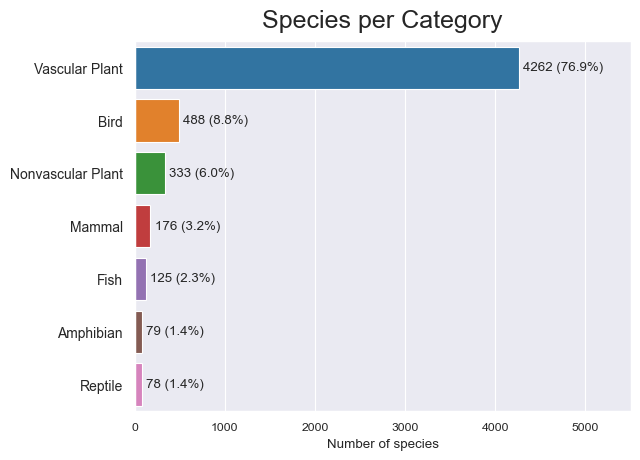

In [16]:
g = sns.countplot(data=info_mod, y='category', order=info_mod.category.value_counts().index, palette=categories_colors)
plt.title('Species per Category', fontsize=18, pad=10)
plt.xlim(0, 5500)
plot_bar_percentages(g, include_values=True)
g.set(ylabel='', xlabel='Number of species')
plt.yticks(fontsize=10)

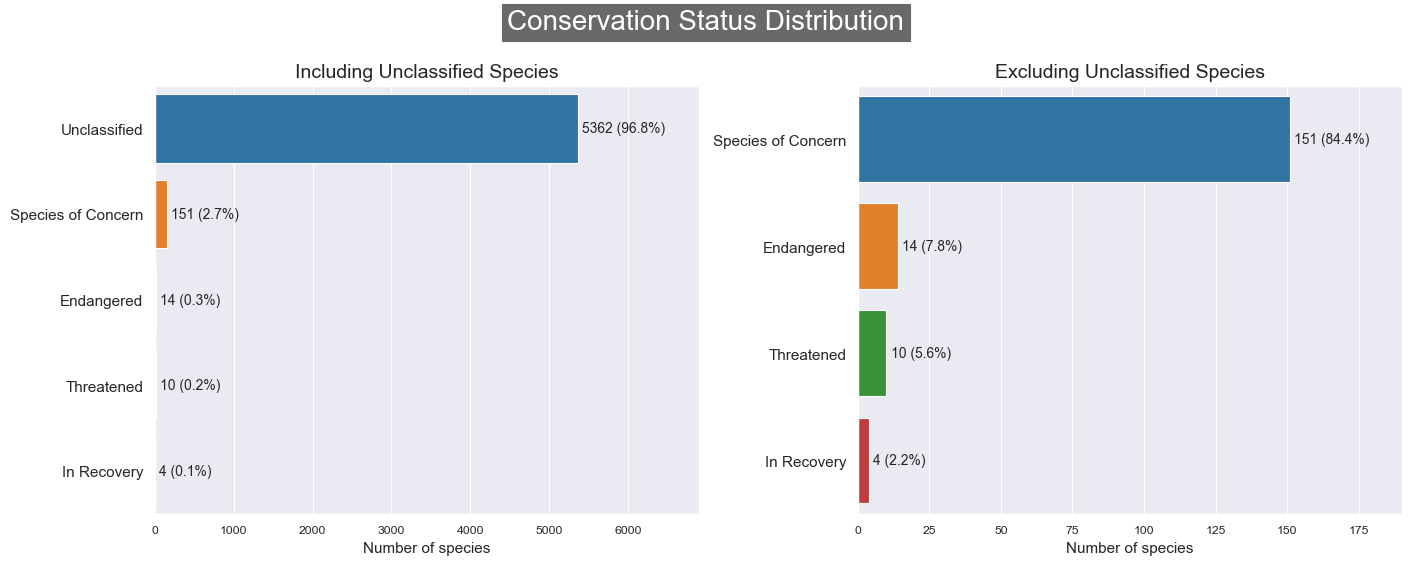

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
fig.suptitle('Conservation Status Distribution', fontsize=20, y=1.1, backgroundcolor='dimgray', color='w')

# Plot first chart
plt.subplot(121)
g1 = sns.countplot(data=info_mod, y='conservation_status', order=info_mod.conservation_status.value_counts().index, ax=axs[0])
g1.set_title('Including Unclassified Species', fontsize=14)
g1.set_xlim(0, 6900)
plot_bar_percentages(g1, include_values=True, fontsize=10)
g1.set(ylabel='', xlabel='Number of species')
plt.yticks(fontsize=11)
plt.xlabel(g1.get_xlabel(), fontsize=11)

# Plot second chart
plt.subplot(122)
g2 = sns.countplot(data=classified, y='conservation_status', order=classified.conservation_status.value_counts().index, ax=axs[1])
g2.set_title('Excluding Unclassified Species', fontsize=14)
g2.set_xlim(0, 190)
plot_bar_percentages(g2, include_values=True, fontsize=10)
g2.set(ylabel='', xlabel='Number of species')
plt.yticks(fontsize=11)
plt.xlabel(g1.get_xlabel(), fontsize=11);

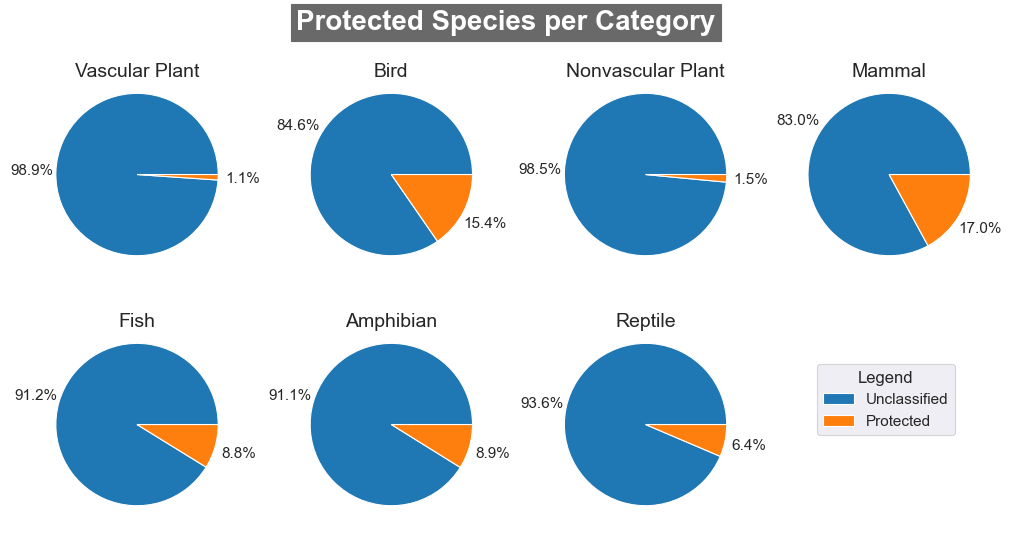

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), layout='constrained')
fig.suptitle('Protected Species per Category', fontsize=20, fontweight='bold', y=1.08, backgroundcolor='dimgray', color='w')

# Remove blank axes
fig.delaxes(axs[1, 3])

# Plot each category chart
for i, category in enumerate(info_mod.category.value_counts().index, start=1):
    plt.subplot(2, 4, i)
    data = info_mod[info_mod.category == category]['is_protected'].value_counts()
    _, _, autopcts = plt.pie(data, autopct='%.1f%%', pctdistance=1.3)
    plt.title(f'{category}', fontsize=14, y=0.94)

    for pct in autopcts:
        pct.set_fontsize(11)

# Create a legend in the last subplot
legend_labels = ['Unclassified', 'Protected']
fig.legend(title='Legend', labels=legend_labels, loc='center',
           bbox_to_anchor=(0.88, 0.3),
           title_fontsize=12,
           fontsize=11
        );

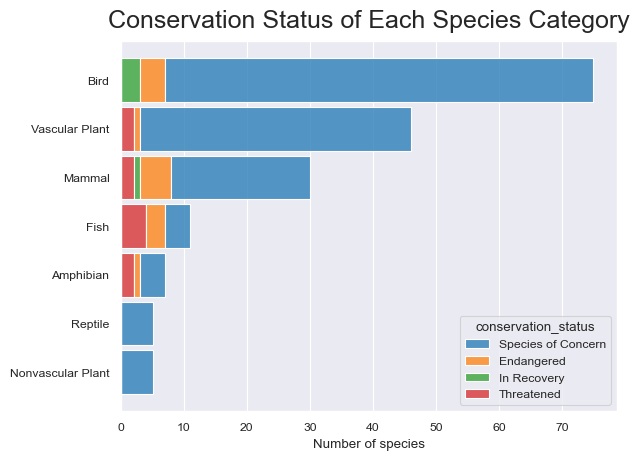

In [19]:
# Sort DF by category counts
category_counts = classified['category'].value_counts()
sorted_classified = classified.sort_values(by='category', key=lambda x: x.map(category_counts), ascending=False)

# Plot species categories by conservation status, excluding unclassified species
g = sns.histplot(data=sorted_classified, y='category', hue='conservation_status', multiple='stack', shrink=0.9)
g.grid(axis='y')
plt.title('Conservation Status of Each Species Category', fontsize=18, pad=10)
plt.ylabel('')
plt.xlabel('Number of species');

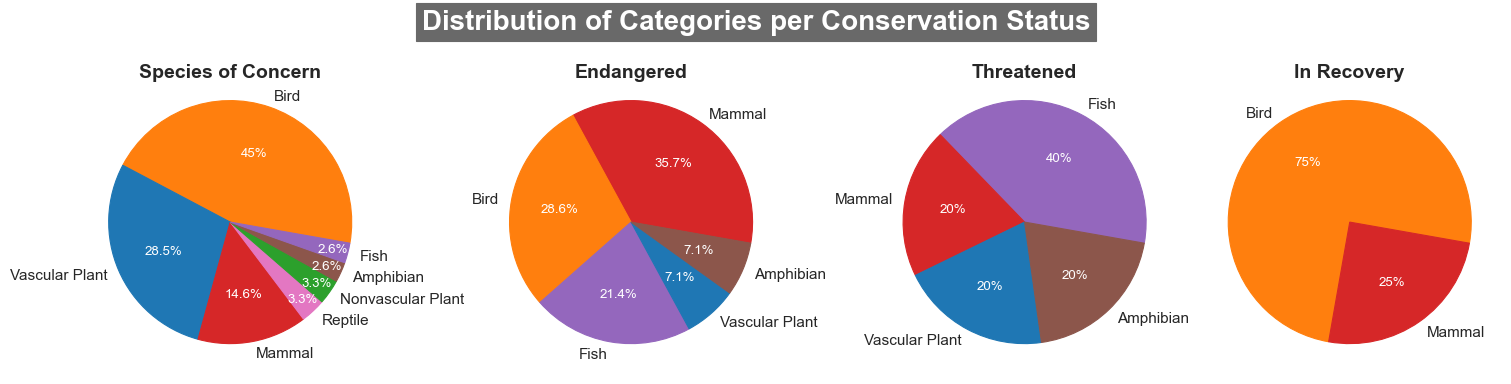

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4), layout='constrained')
fig.suptitle('Distribution of Categories per Conservation Status', fontsize=20, fontweight='bold', backgroundcolor='dimgray', color='w')

for i, status in enumerate(classified.conservation_status.unique(), start=1):
    plt.subplot(1, 4, i)
    
    # Plot pie chart for each conservation status
    data = classified[classified.conservation_status == status]['category'].value_counts()
    patches, texts, autopcts = plt.pie(data, labels=data.index, autopct=lambda pct: pct_label(pct), startangle=-10)

    # Standardize Categories colors
    for patch in patches:
        category = patch.get_label()
        color = categories_colors[category]
        patch.set(color=color)

    # Adjust labels
    for text in texts:
        text.set_fontsize(11)
    
    # Modify each pct label
    pct_adjust(autopcts, distance=1.45)
    
    # Set pie chart title
    plt.title(f'{status}', fontsize=14, y=0.95, weight='bold')

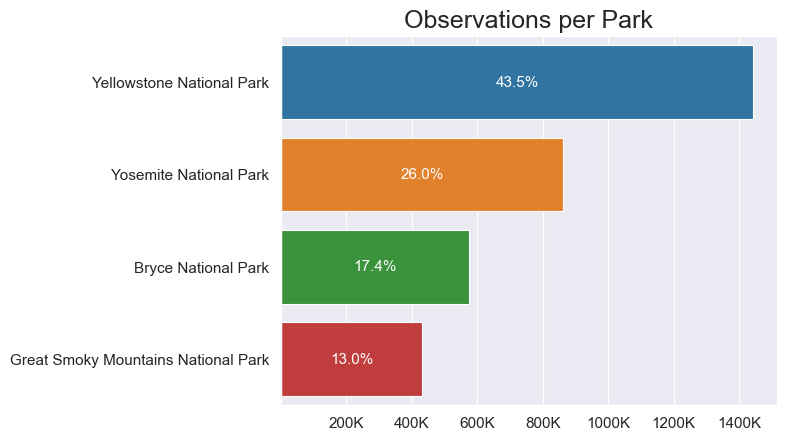

In [21]:
# Plot observations per park
observations_count = obs.groupby('park_name').observations.sum().sort_values(ascending=False)
g = sns.barplot(x=observations_count.values, y=observations_count.index)

# Adjust chart labels
g.set_xticks(range(0, 1500000, 200000))
g.set_xticklabels([f'{x/1000:.0f}K'  if x != 0 else '' for x in range(0, 1500000, 200000)])
plt.title('Observations per Park', fontsize=18)
plt.ylabel('')
plot_bar_percentages(g, label_type='center', padding=0, color='white', fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11);

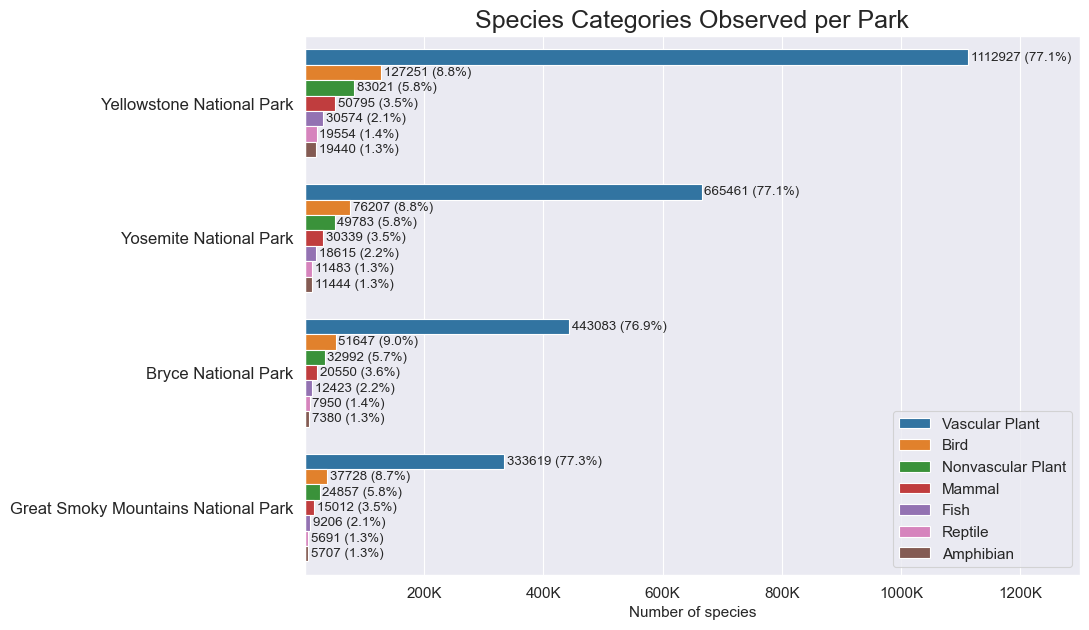

In [22]:
# Prepare DF to be plotted
park_category = merge.groupby(['park_name', 'category'])['observations'].sum().reset_index()
cat_count = park_category.groupby(['category'])['observations'].sum().sort_values(ascending=False)

# Sort DF by observations count
sorted_park_category = park_category.sort_values(by=['park_name', 'category'], key=lambda col: col.map(cat_count), ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 7))
g = sns.barplot(data=sorted_park_category, x='observations', y='park_name', hue='category', order=observations_count.index, palette=categories_colors)

g.set_xticks(range(0, 1500000, 200000))
g.set_xticklabels([f'{x/1000:.0f}K'  if x != 0 else '' for x in range(0, 1500000, 200000)])
g.set_xlim(0, 1300000)
g.legend(loc='lower right', fontsize=11)
plt.title('Species Categories Observed per Park', fontsize=18)
plt.ylabel('')
plot_bar_percentages(g, include_values=True, padding=2)
plt.yticks(fontsize=12)
plt.xticks(fontsize=11)
plt.xlabel(g1.get_xlabel(), fontsize=11);

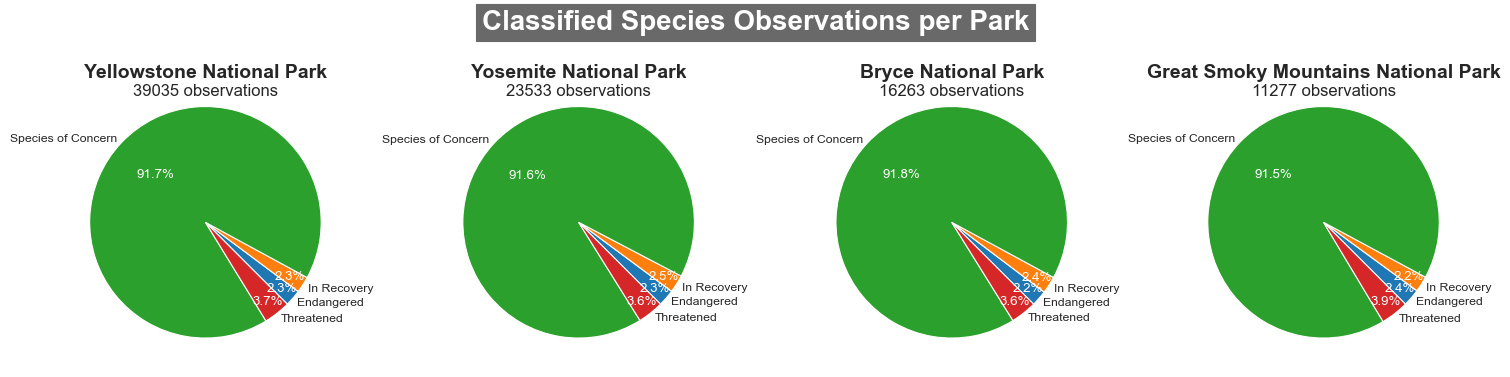

In [23]:
# Plot 1 pie chart for each park's classfied species observation
fig, axs = plt.subplots(1, 4, figsize=(15, 4), layout='constrained')
fig.suptitle('Classified Species Observations per Park', fontsize=20, fontweight='bold', backgroundcolor='dimgray', color='w')

# Prepare DF to be plotted
park_conservation = merge[merge.conservation_status != 'Unclassified']\
    .groupby(['park_name', 'conservation_status'])['observations'].sum()\
        .reset_index()

# Plot each chart
for i, park in enumerate(observations_count.index, start=1):
    plt.subplot(1, 4, i)
    
    # Plot pie chart for each park
    data = park_conservation[park_conservation.park_name == park]
    _, _, autopcts = plt.pie(x='observations', data=data, labels='conservation_status', autopct=lambda pct: pct_label(pct), startangle=-45, labeldistance=1.05)
    
    # Modify each pct label
    pct_adjust(autopcts, distance=1.45)
    
    # Set pie chart title
    count = data.observations.sum()
    plt.text(0, 1.25, f'{park}',fontsize=14, fontweight='bold', ha='center')
    plt.text(0, 1.1,f'{count} observations', fontsize=12, ha='center')

In [24]:
stopwords = {'Common', 'Northern', 'American', 'Eastern', 'Western', 'California', 
             'Southern', 'Mountain', 'White', 'Yellow', 'Red', 'Gray', 'Brown', 'Or',
             'Great', 'Black', 'Water', 'Chorus', 'Mud', 'Spotted', 'Hairy'}

# Count the number of most common species per category
categories_common_names = {}
for category in info.category.unique():
    words = []
    for name in info[info.category == category]['common_names']:
        names = set(name.replace(',', '').replace('(', '').replace(')', '').split())
        names = names - stopwords
        words.extend(names)
    
    categories_common_names[category] = Counter(words)

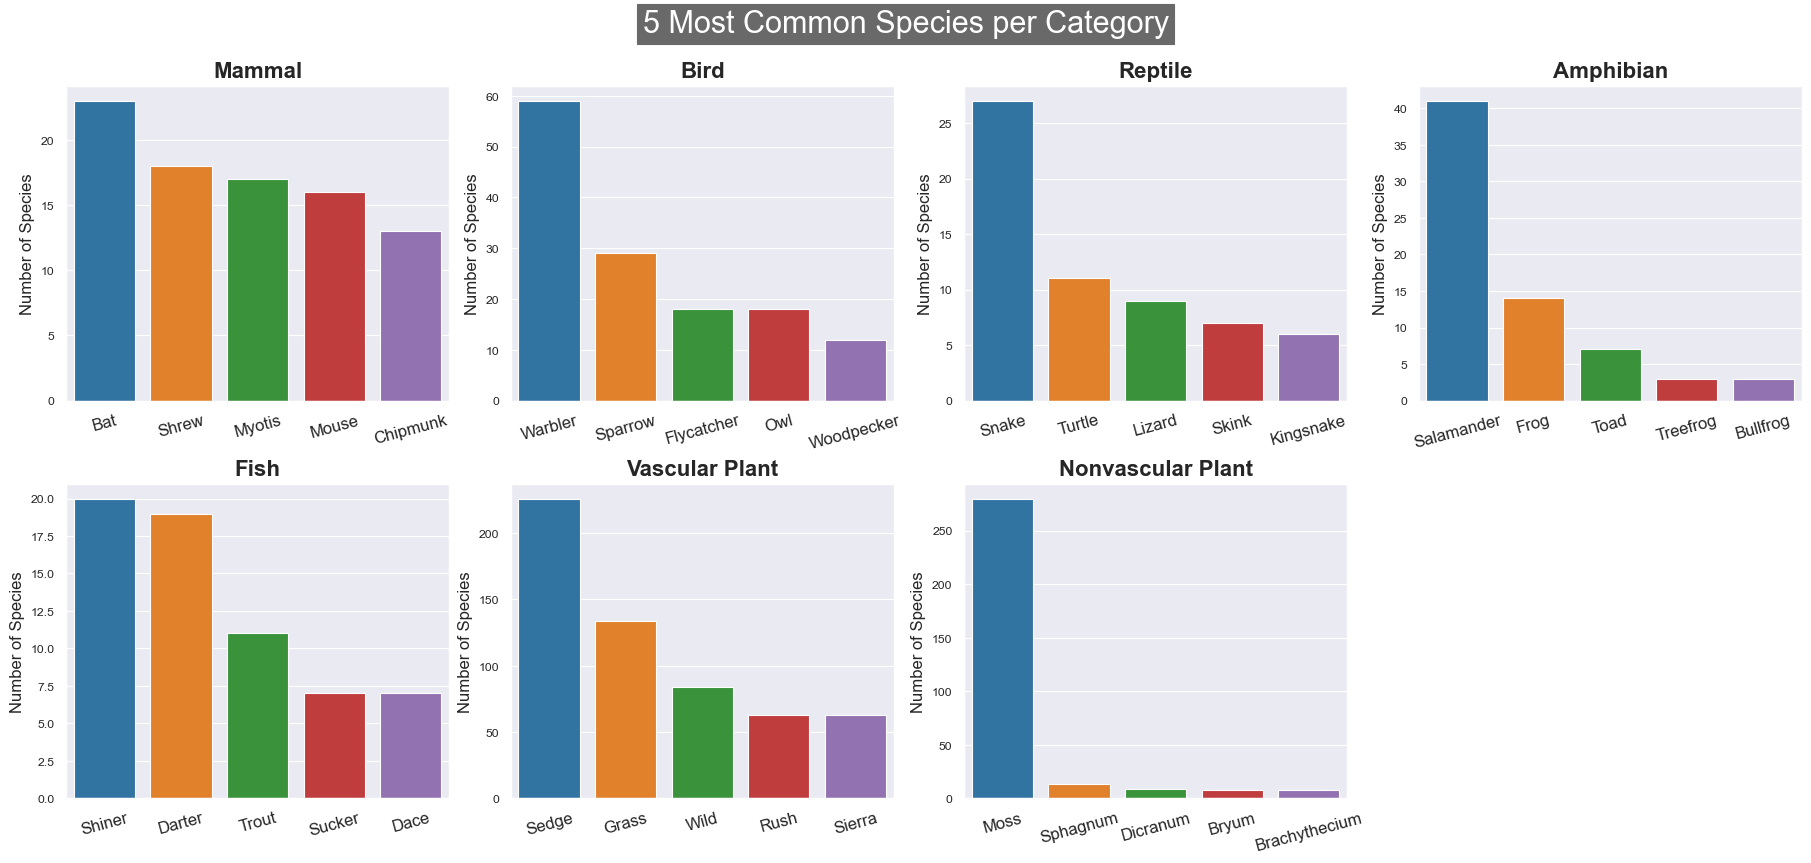

In [25]:
# Plot X most common species per category
qty = 5

fig, axs = plt.subplots(2, 4, figsize=(18, 8), layout='constrained')
fig.suptitle(f'{qty} Most Common Species per Category', fontsize=22, backgroundcolor='dimgrey', color='w', y=1.06)

for i, (category, counter) in enumerate(categories_common_names.items(), start=1):
    ax = plt.subplot(2, 4, i)
    plt.title(f'{category}', fontsize=16, fontweight='bold')

    data = counter.most_common(qty)
    species = [item[0] for item in data]
    counts = [item[1] for item in data]

    g = sns.barplot(x=species, y=counts)
    plt.xticks(fontsize=12, rotation=15)
    g.set_ylabel('Number of Species', fontsize=12)

plt.delaxes(axs[1, 3])


Mammal:
 Species  Count
     Bat     23
   Shrew     18
  Myotis     17
   Mouse     16
Chipmunk     13

Bird:
   Species  Count
   Warbler     59
   Sparrow     29
Flycatcher     18
       Owl     18
Woodpecker     12

Reptile:
  Species  Count
    Snake     27
   Turtle     11
   Lizard      9
    Skink      7
Kingsnake      6

Amphibian:
   Species  Count
Salamander     41
      Frog     14
      Toad      7
  Treefrog      3
  Bullfrog      3

Fish:
Species  Count
 Shiner     20
 Darter     19
  Trout     11
 Sucker      7
   Dace      7

Vascular Plant:
Species  Count
  Sedge    226
  Grass    134
   Wild     84
   Rush     63
 Sierra     63

Nonvascular Plant:
      Species  Count
         Moss    280
     Sphagnum     13
     Dicranum      9
        Bryum      8
Brachythecium      8


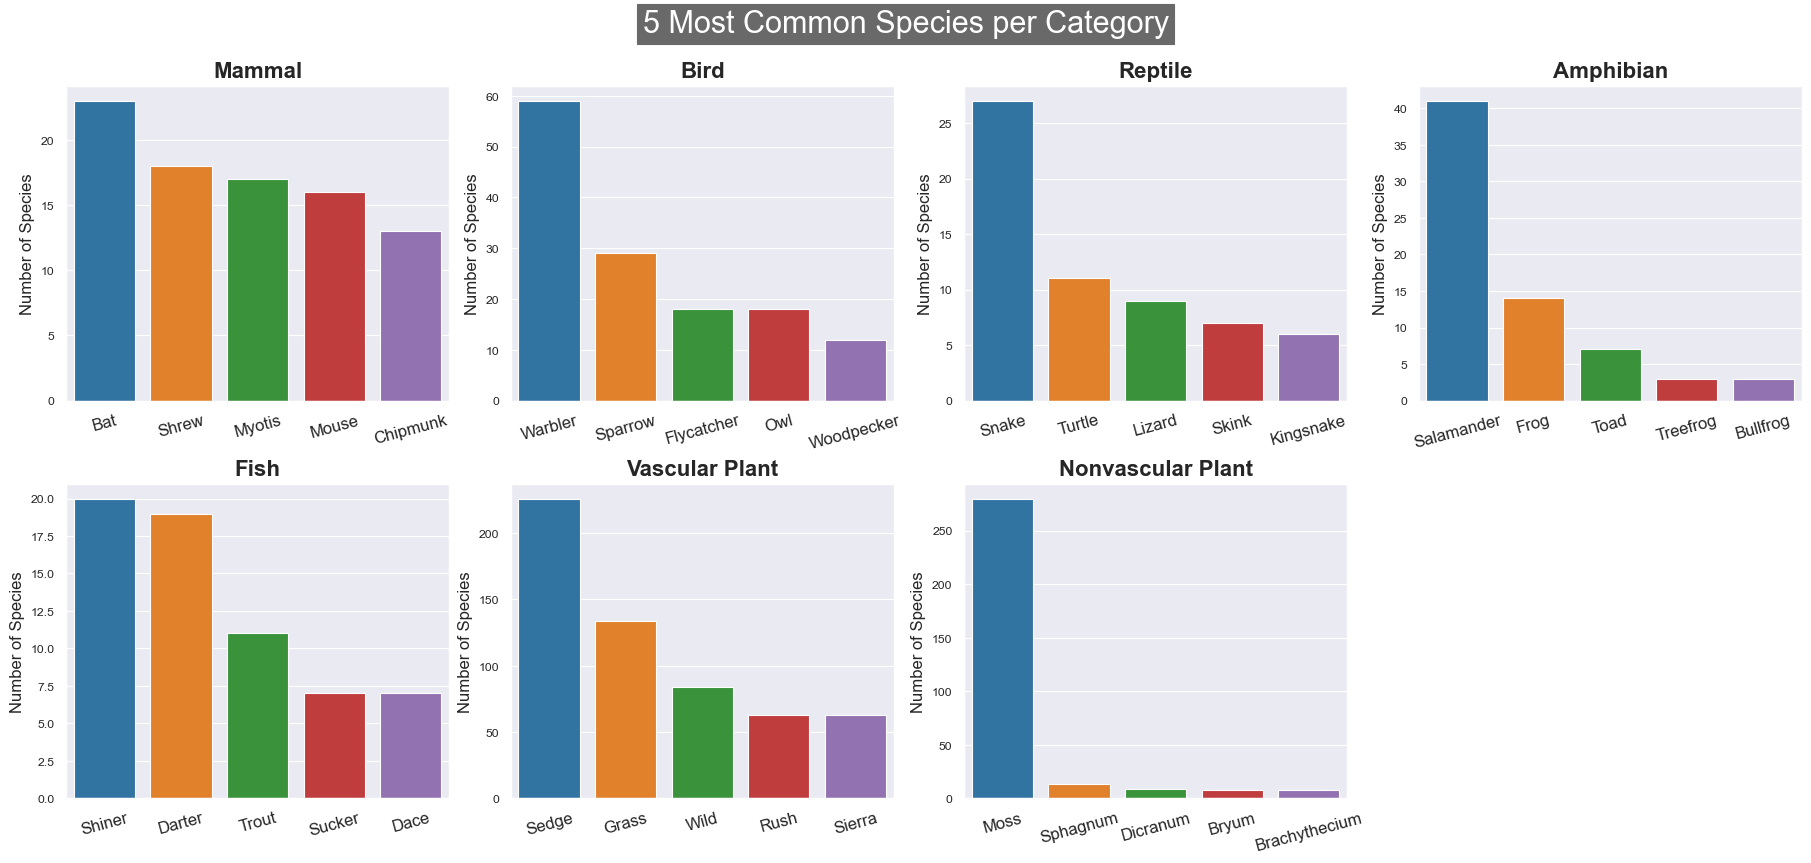

In [26]:
import pandas as pd

qty = 5

fig, axs = plt.subplots(2, 4, figsize=(18, 8), layout='constrained')
fig.suptitle(f'{qty} Most Common Species per Category', fontsize=22, backgroundcolor='dimgrey', color='w', y=1.06)

for i, (category, counter) in enumerate(categories_common_names.items(), start=1):
    ax = plt.subplot(2, 4, i)
    plt.title(f'{category}', fontsize=16, fontweight='bold')

    data = counter.most_common(qty)
    species = [item[0] for item in data]
    counts = [item[1] for item in data]

    g = sns.barplot(x=species, y=counts)
    plt.xticks(fontsize=12, rotation=15)
    g.set_ylabel('Number of Species', fontsize=12)

    # Print data in tabular form
    df = pd.DataFrame(data, columns=['Species', 'Count'])
    print(f'\n{category}:\n{df.to_string(index=False)}')

plt.delaxes(axs[1, 3])


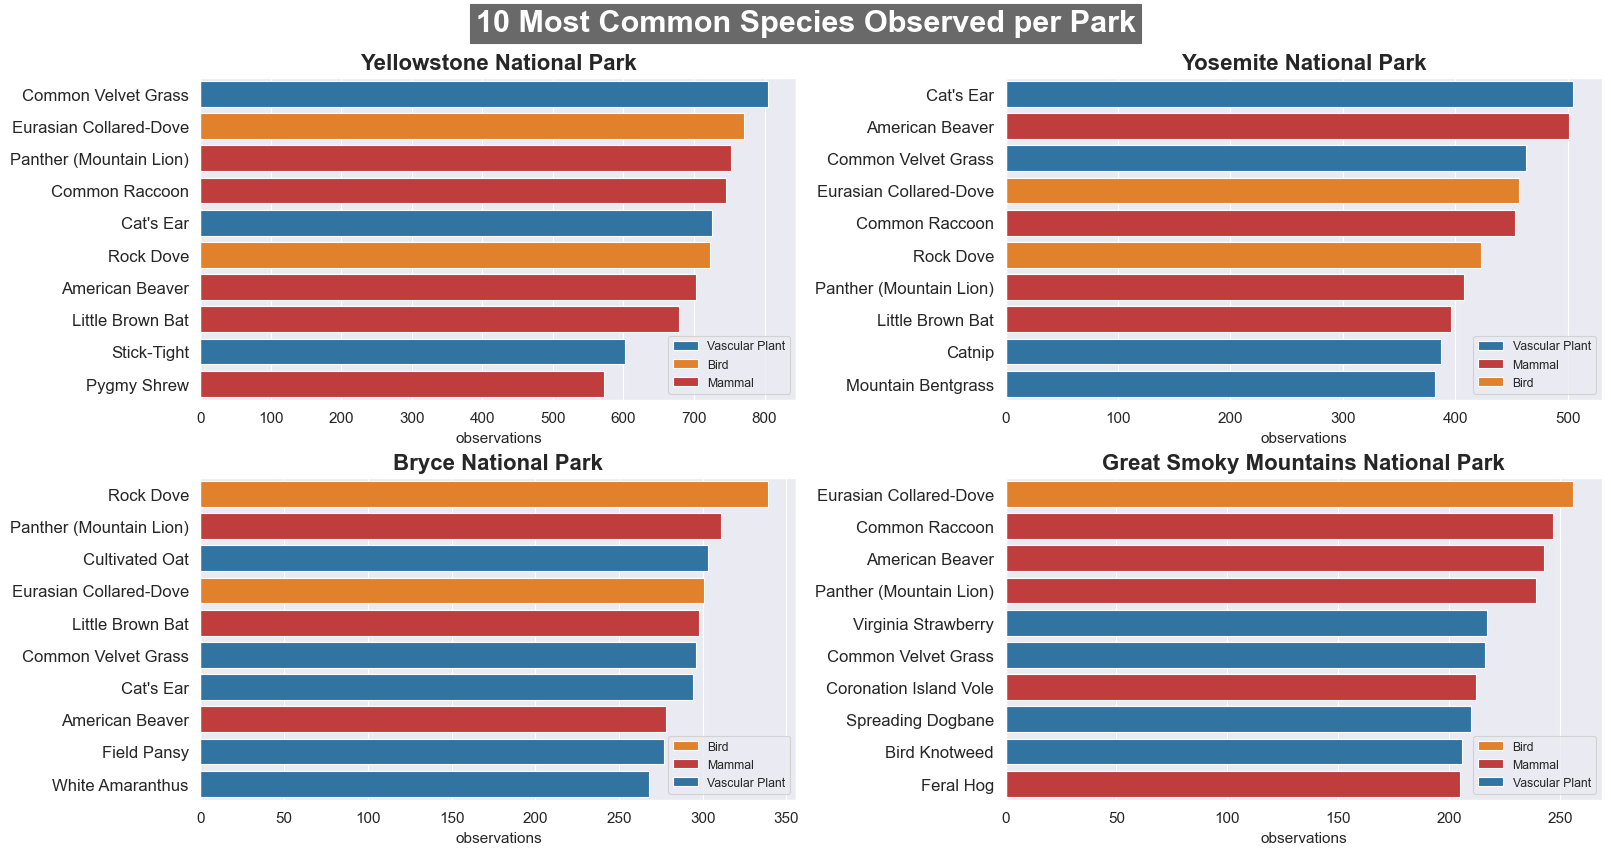

In [22]:
# Plot k most common species observed per park
k = 10

fig, axs = plt.subplots(2, 2, figsize=(16, 8), layout='constrained')
fig.suptitle(f'{k} Most Common Species Observed per Park', fontsize=22, fontweight='bold', backgroundcolor='dimgrey', color='w', y=1.05)

for i, park in enumerate(observations_count.index, start=1):
    # Prepare data to be plotted
    obs_count = merge[(merge.park_name == park)]\
        .groupby(['scientific_name', 'category'])['observations'].sum().sort_values(ascending=False).reset_index()[:k]

    obs_count['common_name'] = obs_count.apply(lambda row: merge[merge.scientific_name == row.scientific_name]['common_names'].values[0].split(',')[0], axis=1)

    # Prepare Axes
    plt.subplot(2, 2, i)
    plt.title(f'{park}', fontsize=16, fontweight='bold')
    
    # Draw Chart
    g = sns.barplot(data=obs_count, y='common_name', x='observations', hue='category', dodge=False, palette=categories_colors)
    plt.ylabel('')
    plt.xlabel(g.get_xlabel(), fontsize=11)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=11)
    g.legend(loc='lower right')